In [18]:
import tensorflow as tf
import numpy as np
import os, random
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import glob

In [ ]:
# Reproducibility
np.random.seed(42); random.seed(42); tf.random.set_seed(42)

# Input dimensions
IMG_WIDTH  = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Data paths
TRAIN_PATH = 'data-science-bowl-2018/stage1_train'
TEST_PATH  = 'data-science-bowl-2018/stage1_test'

# Walk folders
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids  = next(os.walk(TEST_PATH))[1]

Resizing training images and building unified masks


100%|██████████| 670/670 [00:33<00:00, 19.72it/s]


Resizing test images


100%|██████████| 65/65 [00:00<00:00, 95.10it/s]

Data preparation completed


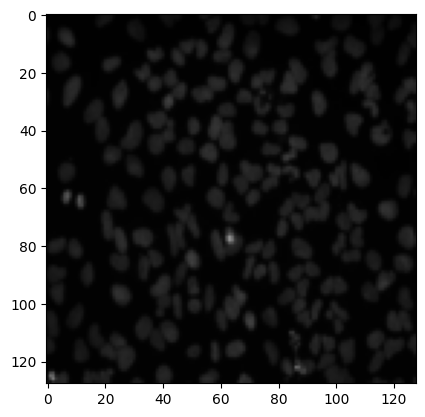

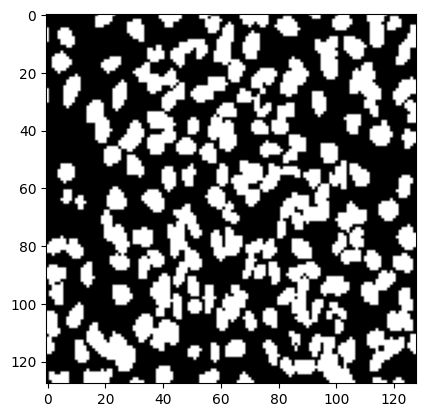

In [ ]:
# making empty dataloadrs 
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1),            dtype=np.float32)
X_test  = np.zeros((len(test_ids),  IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

print("Resizing training images and building unified masks")
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    # image
    img = imread(os.path.join(path, 'images', id_ + '.png'))[:, :, :IMG_CHANNELS]
    img_resized = resize(
        img, (IMG_HEIGHT, IMG_WIDTH),
        mode='constant', preserve_range=True, anti_aliasing=True
    ).astype(np.float32)
    X_train[n] = img_resized

    # unified masks
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    mask_dir = os.path.join(path, 'masks')
    for maskfile in next(os.walk(mask_dir))[2]:
        m = imread(os.path.join(mask_dir, maskfile))
        m_resized = resize(
            m, (IMG_HEIGHT, IMG_WIDTH),
            mode='constant', preserve_range=True, anti_aliasing=False
        )
        m_resized = np.expand_dims(m_resized, -1)
        mask = np.maximum(mask, (m_resized > 0))   # accumulate per-pixel OR

    Y_train[n] = mask.astype(np.float32)  # 0/1 float

print("Resizing test images")
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img = imread(os.path.join(path, 'images', id_ + '.png'))[:, :, :IMG_CHANNELS]
    sizes_test.append(img.shape[:2])
    img_resized = resize(
        img, (IMG_HEIGHT, IMG_WIDTH),
        mode='constant', preserve_range=True, anti_aliasing=True
    ).astype(np.float32)
    X_test[n] = img_resized

print("Data preparation completed")

# check
plt.imshow(X_train[30].astype(np.uint8)); plt.show()
plt.imshow(np.squeeze(Y_train[30]), cmap='gray'); plt.show()


In [ ]:

# U-Net implementation

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
x = tf.keras.layers.Lambda(lambda z: z / 255.0)(inputs)  # normalize to [0,1]

# Encoder
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
c2 = tf.keras.layers.Dropout(0.2)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

# Decoder
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.Concatenate()([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.Concatenate()([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.Concatenate()([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.Concatenate()([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])



In [ ]:
# Dice metric
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    denom = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    return tf.reduce_mean((2. * intersection + smooth) / (denom + smooth))

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [ ]:
# Compile 
model.compile(optimizer='adam', loss=bce_dice, metrics=[dice_coef])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Callbacks
checkpointers = tf.keras.callbacks.ModelCheckpoint(
    'model_for_nuclei_segmentation.keras',
    monitor='val_loss', mode='min', save_best_only=True, verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)
callbacks = [checkpointers, early_stopping]


In [ ]:
# Train
results = model.fit(
    X_train, Y_train,
    validation_split=0.1,
    batch_size=8,
    epochs=120,             
    shuffle=True,
    callbacks=callbacks
)

In [ ]:
# 1) check
print(os.getcwd())
print(os.path.exists('model_for_nuclei_segmentation.keras'))
print(glob.glob('**/*.keras', recursive=True))  # find it if you’re unsure
)
MODEL_PATH = 'model_for_nuclei_segmentation.keras'

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32); y_pred = tf.cast(y_pred, tf.float32)
    inter = tf.reduce_sum(y_true*y_pred, axis=[1,2,3])
    denom = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    return tf.reduce_mean((2.*inter + smooth)/(denom + smooth))

def dice_loss(y_true, y_pred): return 1.0 - dice_coef(y_true, y_pred)
def bce_dice(y_true, y_pred):  return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss, 'bce_dice': bce_dice},
    compile=False,safe_mode=False
)


/Users/indreshmr/Image-segmentation-unet
True
['model_for_nuclei_segmentation.keras']


In [ ]:
#Predict on all test images
preds_prob = model.predict(X_test, batch_size=8, verbose=1) 

#  3) Threshold 
THRESH = 0.5
preds_bin_128 = (preds_prob > THRESH).astype(np.uint8)

#4) Resize masks back to original dimensions

preds_bin_orig = []
for i in range(len(preds_bin_128)):
    h, w = sizes_test[i]                 # original size for this image
    m = resize(
        preds_bin_128[i, :, :, 0], (h, w),
        order=0, preserve_range=True, anti_aliasing=False
    ).astype(np.uint8)
    preds_bin_orig.append(m)




9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


In [26]:
os.makedirs('pred_masks_instance', exist_ok=True)
for i, id_ in enumerate(test_ids):
    plt.figure(figsize=(4,4))
    plt.axis('off')
    plt.imshow(preds_bin_orig[i]) 
    plt.tight_layout()
    plt.savefig(f'pred_masks_instance/{id_}.png', bbox_inches='tight', pad_inches=0)
    plt.close()
